In [2]:
import array
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

# Identifty Data File - Select Data - Scaling Factors #
The goal of the following section of code is to scale current and voltage units into units of Amperes and Volts.


<u>How to Read Scaling Factors from IVVI Data:</u>

<center>
<img src="instr_img/stp2.png" width="550">
</center>
    
<i>NOTE: pay special attention to the sign of the back-gate voltage scaling factor. The data may be negative in sign, but the plots may look positive because the IVVI software can display sign reversed data. Conversely, the keithley output is scaled without sign reversal. </i>
    
    
<u>How to select propper data collumns:</u>

<center>
<img src="instr_img/col_stp.png" width="450">
</center>
    
<b> xdata - the backgate voltage </b>
    
<b> ydata - current output </b>
 
<i> REMEMBER: Python count starts at 0. So collumn 1 in data file will be collumn 0 in the code. </i>

In [3]:
## Opening data file. ##

filename = '020124_M3635_60nm_2/data_83.dat'
with open(filename, 'r') as f:
    data = f.readlines()

fit = []

## Trimming data file. ##
 
for d in data:
    
    # "if not" statement cuts leading text in .dat file
    if not (d.startswith('#') or d.startswith('\n')):
        fit.append([float(x) for x in d.split('\t')])
 
# translate python array into numpy array 
fitnp = np.asarray(fit)

n = len(fitnp) # length of array 
S = np.empty(n) # defines empty array of legnth n

## SCALING FACTORS ##

xdata = fitnp[0:n,0] * 15e-3
ydata = fitnp[0:n,3] * 1e-6 

# Capacitance Selection #

<u> You have to use an SEM to measure contact spacing between leads on a nanowire: </u>

<center>
<img src="instr_img/cntct_spc.jpg" width="500">
</center>
    
<u> Use the spacing to estimate the capacitance from the following chart: </u>

<center>
<img src="instr_img/chart.png" width="600">
</center>

NOTE: the orange and the green curve are exactly the same. 

- 0nm means the wire is bare and uncoated. As long as you have bare wires: you can use the orange graph to estimate capacitance. 
- CdTe is the material coating the wire. 
- SiOx and HfOx are substrate materials. 


<i> Conceptually the capacitance we're accounting for here is the capacitance between the leads on your device and the backgate across the dielectric material of your microchip layer stack. </i> 


In [4]:
# 4.129e-5, 15.48375e-18, 1e-3    

# contact spacing - cm #
L = 3e-5

# capacitance - faradays #
cap = 11.25e-18

# Vbias - V #
Vbias = 10e-3

# Y-Fit Function #

Defines the fitting of the following function: 

<img src="instr_img/funct.png" width="200">


In [1]:
## NOTE: Vth - determined using scipy curve_fit function. Determines where ##
## the function goes to zero. ##

## FIT FUNCTION ## 
# Used to fit data 
def yfit(x, vth, rc, u):
    
    # Fit Function
    I = (Vbias/rc) - Vbias*(L**2)/((L**2)*rc + (rc**2)*u*cap*(x-vth))
    
    # Trimming
    for i in range(n):
        
        if x[i]<vth:
            S[i] = 0     
        else:
            S[i] = 1
            
    return I*S


## TRUNCATION FUNCTION ##
# Used to truncate the part of the fit curve in the region where it goes
# to zero. This is pureply for cosmetic data vizualization purposes. 

def trunc(x, vth, rc, u):
    
    # Truncated array 
    trunc_vb = []
    trunc_curr = []

    # Fit Function
    I = (Vbias/rc) - Vbias*(L**2)/((L**2)*rc + (rc**2)*u*cap*(x-vth))
      
    # Trimming
    for i in range(n):
        
        if x[i]>=vth:
            
            trunc_vb.append(x[i])
            trunc_curr.append(I[i])
            
    return trunc_vb, trunc_curr

# Readout and Plots # 
- L = spacing between nanowire contacts (cm).
- Vbias = source-drain bias on the nanowire (V). 
    - NOTE: keep track of signs on the IVVI rack.

The "curve_fit" function returns popt, and pcov:

- popt is an array containing [Thershold Voltage (V), Contact Resistance (Ω), Mobility ($\frac{cm^2}{V * s}$)]
    - Contact Resistance - resistance between the leads across the nanowire. 
    - Mobility - Carrier mobility of the nanowire. 
- perr (by way of pcov) is an array containing corresponding standard deviation falues to popt values. 


[1.6008 3420.2679 3204.8026] [0.0776 70.1263 120.1652]


Text(0.5, 0.2, '$\\mu$ = 3.204803e+03 $\\frac{cm^2}{V \\cdot s}$')

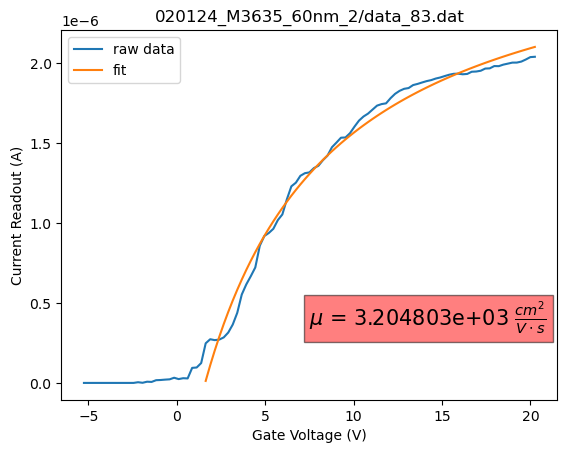

In [6]:
# fitting 
popt,pcov = curve_fit(yfit, xdata, ydata)
perr = np.sqrt(np.diag(pcov))

print(popt,perr)

#plot raw data 
plt.plot(xdata, ydata)

#plot fit
plt.plot(trunc(xdata,popt[0], popt[1], popt[2])[0],
         trunc(xdata,popt[0], popt[1], popt[2])[1])
plt.xlabel("Gate Voltage (V)")
plt.ylabel("Current Readout (A)")
plt.title(filename)
plt.legend(['raw data', "fit"])

#print mobility on plot 
plt.annotate("$\mu$ = " + str("{:e}".format(popt[2])) + r" $\frac{cm^2}{V \cdot s}$", 
             xy=(0.5, 0.2),  xycoords='axes fraction', 
             fontsize=15, 
             bbox=dict(facecolor='red', alpha=0.5))

# PANDAS Work #


Contact Spacing: 3e-05 cm
Capacitance: 1.125e-17 F
Bias Voltage: 0.01 V


4.21       µ [cm^2/(V*s)]    Resistance [Ω]    Threshold Voltage [V]
-------  ----------------  ----------------  -----------------------
data_83           3204.8            3420.27                  1.60076
data_84           2042.57           2335.47                  5.34569
data_85           3186.11           3436.19                  1.55048
data_86           1976.92           2202.92                  5.31134
data_87           3441.92           3523.01                  1.85191
data_88           2184.2            2500.76                  5.5627
Average           2672.75           2903.1                   3.53715




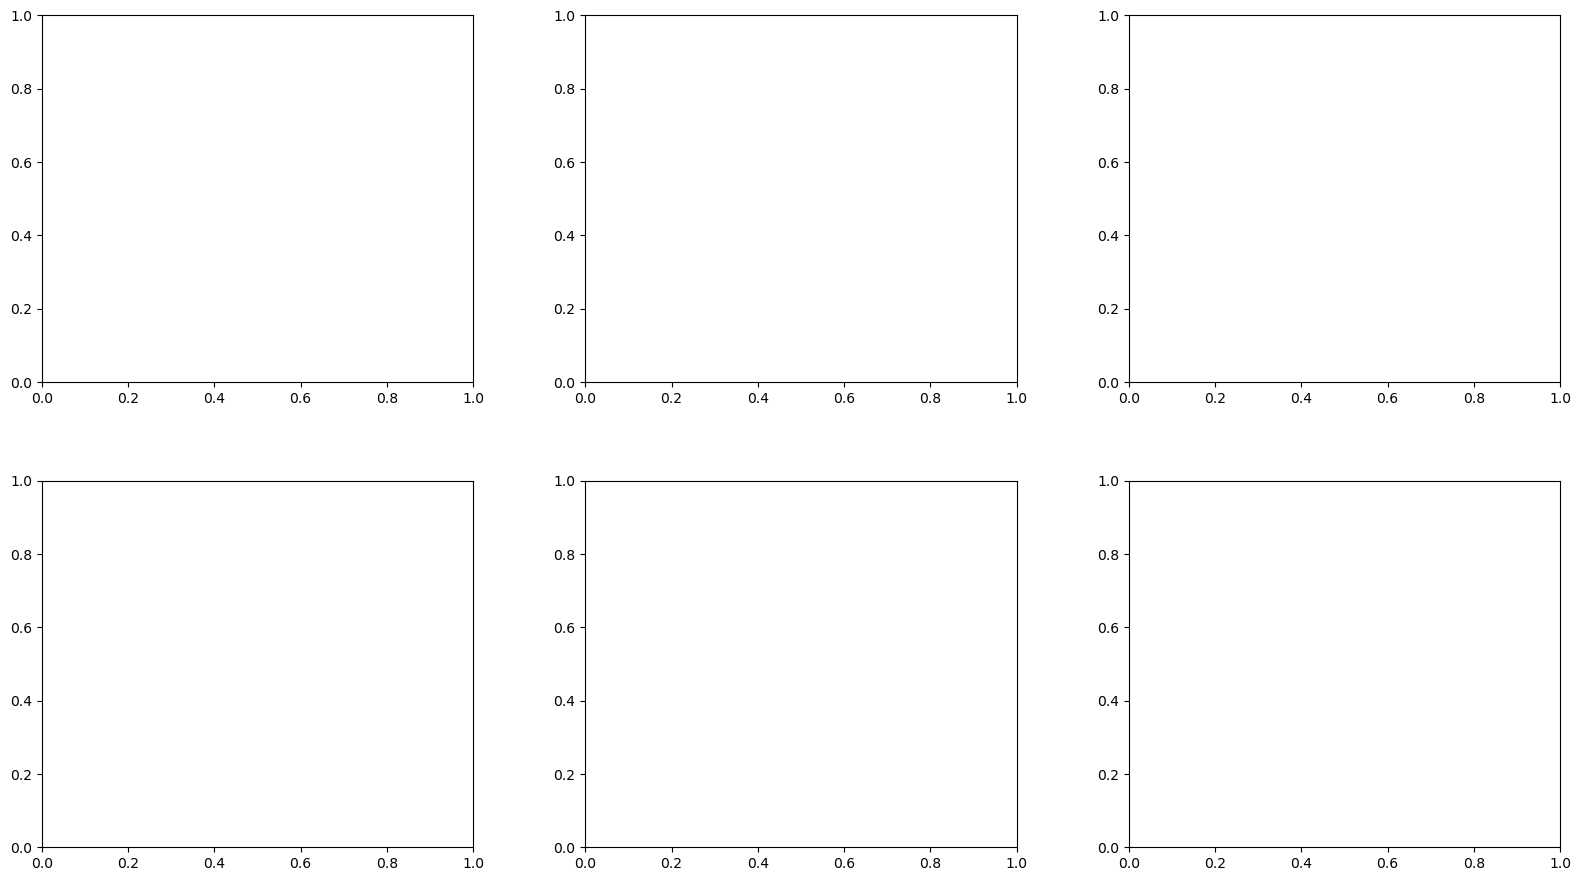

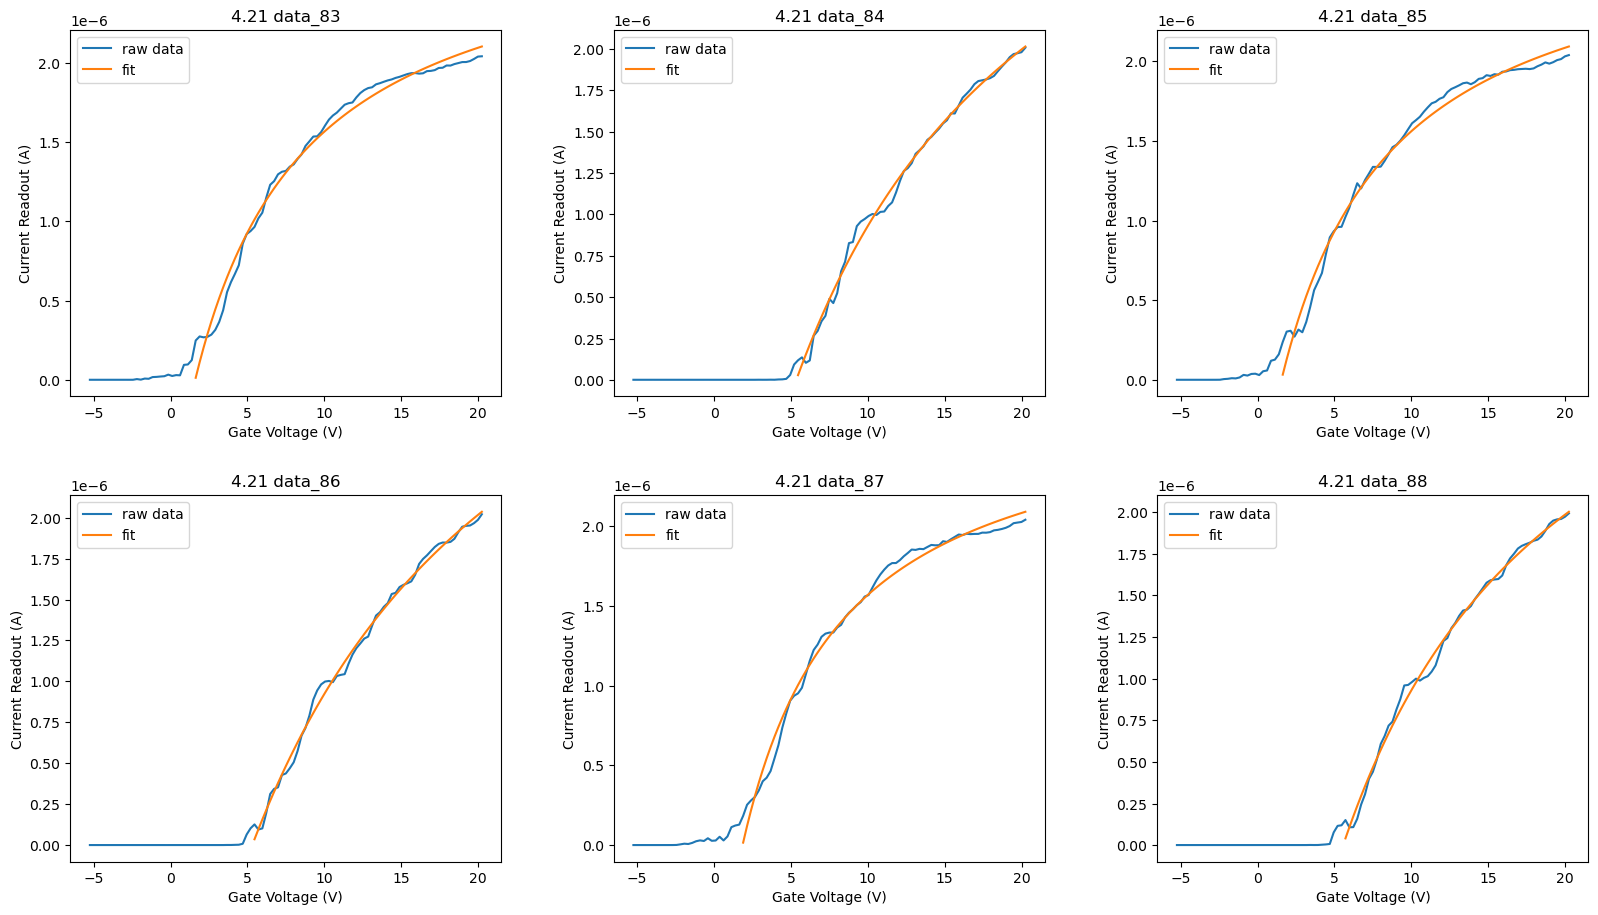

In [15]:
## CODE CHECKS OUT NOW IT WORKS ##
## NEXT STEP IS TO GET CONTACT SPACING ENTERED AS NANOMETERS and ELIMINATING CAPACITANCE. 

import array
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tabulate import tabulate

np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

# I think what's happening here is because its a function we're interpreting everything as
# literal in here but rather should be doing stuff as not literal - Very interesting.

## ALSO VBIAS AND L MUST BE PREDETERMINED  ##
def read_file(filename):
    
    fit = []
    x = 0
    comp_flnm = '020124_M3635_60nm_2/' + filename + ".dat"
    
    with open(comp_flnm, 'r') as f:
        read_file = f.readlines()
    
    for line in read_file:
        
        if not (line.startswith('#') or line.startswith('\n')):
            
            fit.append([float(x) for x in line.split('\t')])
            
    fitnp = np.asarray(fit)
    
    n = len(fitnp)

    Vgate = fitnp[0:n,0] * 15e-3 
    Iout = fitnp[0:n,3] * 1e-6 
    
    return Vgate, Iout


def trunc(x, vth, rc, u):
    
    # Truncated array 
    trunc_vb = []
    trunc_curr = []

    # Fit Function
    I = (Vbias/rc) - Vbias*(L**2)/((L**2)*rc + (rc**2)*u*cap*(x-vth))
      
    # Trimming
    for i in range(n):
        
        if x[i]>=vth:
            
            trunc_vb.append(x[i])
            trunc_curr.append(I[i])
            
    return trunc_vb, trunc_curr

def shape_4_tabulate(Vth, r, mu, data_ids):

    Vth_avg = np.mean(Vth)
    Vth.append(Vth_avg)

    r_avg = np.mean(r)
    r.append(r_avg)

    mu_avg = np.mean(mu)
    mu.append(mu_avg)
    
    if len(data_ids) == 1: 
        Names = data_ids
    
    else: 
        Names = data_ids
        Names.append("Average")

    return Vth, r, mu, Names

data = {
    
    "4.21" : [["data_83", "data_84", "data_85", "data_86", "data_87", "data_88"],
            3e-5, 11.25e-18, 10e-3]
           #contact spacing - cm, capacitance - farads, Vbias - V) 

}

#You may have to do like plt.legend. You can do ax.legend()

for key in data:
    
    if len(data[key][0]) == 6:
        
        fig,axs = plt.subplots(nrows = 2, ncols = 3, figsize = (17,10)) #axs multiple axes # Figure Size
        fig.tight_layout(pad = 5.0)
        
    if len(data[key][0]) == 3:

        fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (17,10)) #axs multiple axes # Figure Size
        fig.tight_layout(pad = 5.0)
        
    if len(data[key][0]) == 1:
        
        fig,axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6)) #axs multiple axes # Figure Size
        fig.tight_layout(pad = 5.0)
        
    else:
        
        fig,axs = plt.subplots(nrows = 2, ncols = 3, figsize = (17,10)) #axs multiple axes # Figure Size
        fig.tight_layout(pad = 5.0)
    

    ## THIS CHECKS OUT -> Correct values are retreived 
    L = data[key][1]
    print("Contact Spacing: " + str(L) + " cm")
    cap = data[key][2]
    print("Capacitance: " + str(cap) + " F")
    Vbias = data[key][3]
    print("Bias Voltage: " + str(Vbias) + " V")
    print("\n")
    
    Vth = []
    r = []
    mu = []
    
    for i, data_file in enumerate(data[key][0]): # i helps enumerate and enumerate
                
        Vg, I = read_file(data_file)
        
        n = len(Vg)
        S = np.empty(n)
         
        def yfit(x, vth, rc, u):
    
            # Fit Function
            I = (Vbias/rc) - Vbias*(L**2)/((L**2)*rc + (rc**2)*u*cap*(x-vth))

            # Trimming
            for i in range(n):

                if x[i]<vth:
                    S[i] = 0     
                else:
                    S[i] = 1

            return I*S
                
        # Extract parameter and StdDev
        popt,pcov = curve_fit(yfit, Vg, I)
        perr = np.sqrt(np.diag(pcov))
        
        ax = np.ravel(axs)[i] #flattens the 2x3 axes into a list of 6 objects and iterates thorugh it.
        ax.plot(Vg, I) # Axes objects have mehtods that do plotting for you. Ax 
                       # has almost same functions as plot

        # fit plot
        ax.plot(trunc(Vg,popt[0], popt[1], popt[2])[0],
                trunc(Vg,popt[0], popt[1], popt[2])[1])
        
        ax.set_xlabel("Gate Voltage (V)")
        ax.set_ylabel("Current Readout (A)")
        ax.set_title(key + " " + data_file)
        ax.legend(['raw data', "fit"])
        
        # Adds Values
        Vth.append(popt[0])
        r.append(popt[1])
        mu.append(popt[2])
        
    Vth, r, mu, Names = shape_4_tabulate(Vth, r, mu, data[key][0])

    head = [key, "µ [cm^2/(V*s)]", "Resistance [Ω]", "Threshold Voltage [V]"]
    
    print(tabulate(list(zip(Names, mu, r, Vth)), headers = head))
    print("\n")
    
    # content2 = tabulate(list(zip(Names, mu, r, Vth)), headers = head)
    # text_file=open("output.csv","w")
    # text_file.write(content2)
    # text_file.close()
    

Contact Spacing: 3e-05 cm
Capacitance: 1.125e-17 F
Bias Voltage: 0.01 V


4.32        µ [cm^2/(V*s)]    Resistance [Ω]    Threshold Voltage [V]
--------  ----------------  ----------------  -----------------------
data_131           615.901          1744.56                 -10.5597
data_132           311.683         -2742.76                   0.89583
data_133           604.221          1692.54                 -10.583
data_134           314.18          -2766.09                   1.08821
data_135           578.804          1573.86                 -11.1223
data_136           329.792         -2516.68                   1.5537
Average            459.097          -502.429                 -4.78787




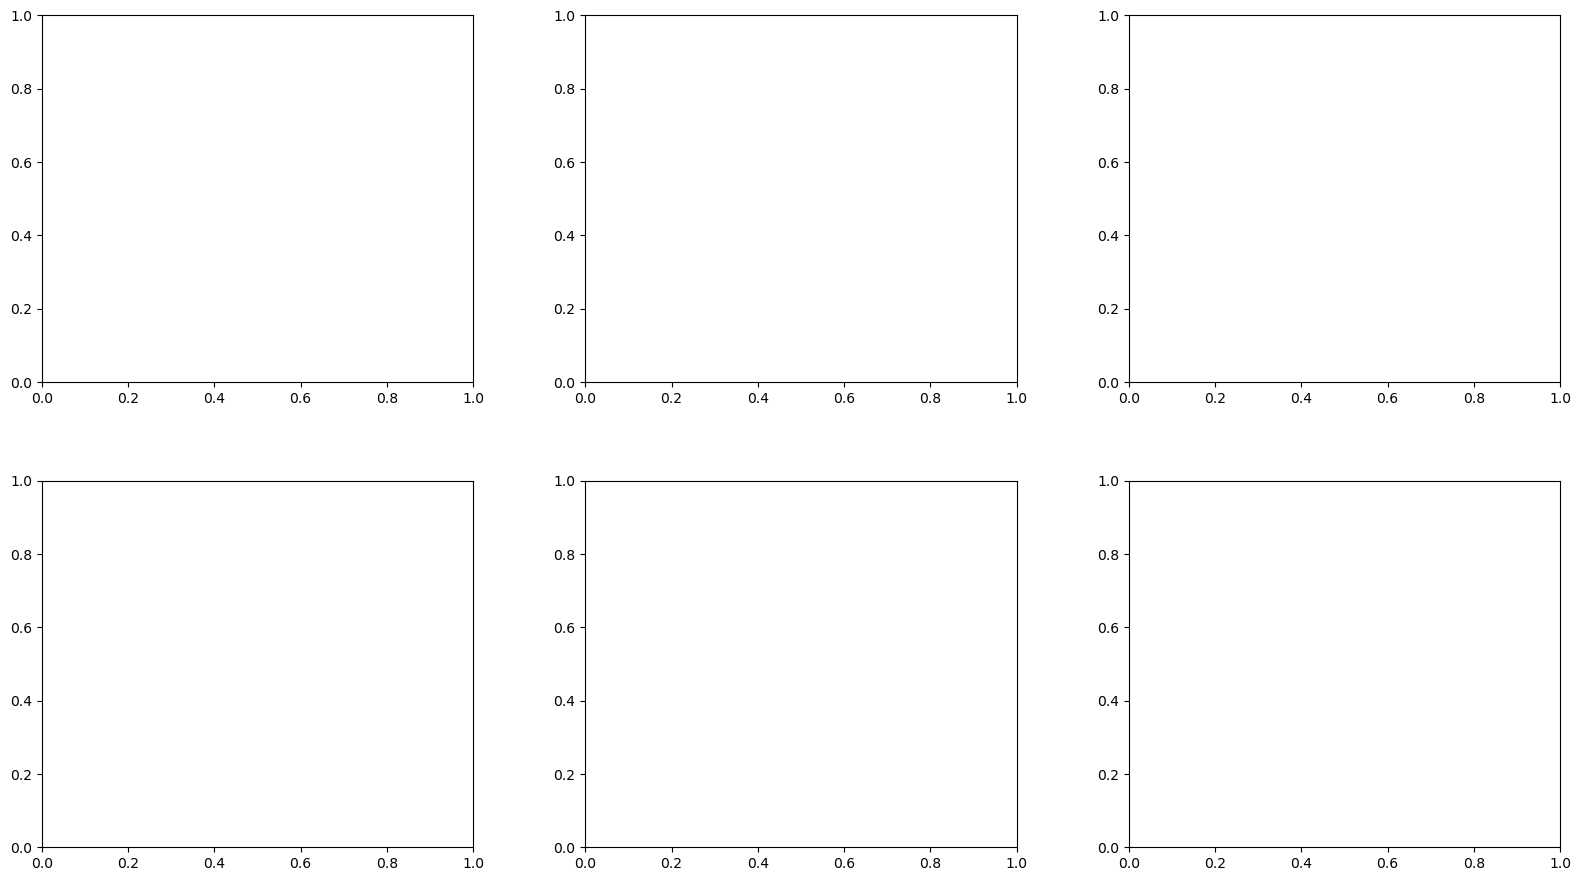

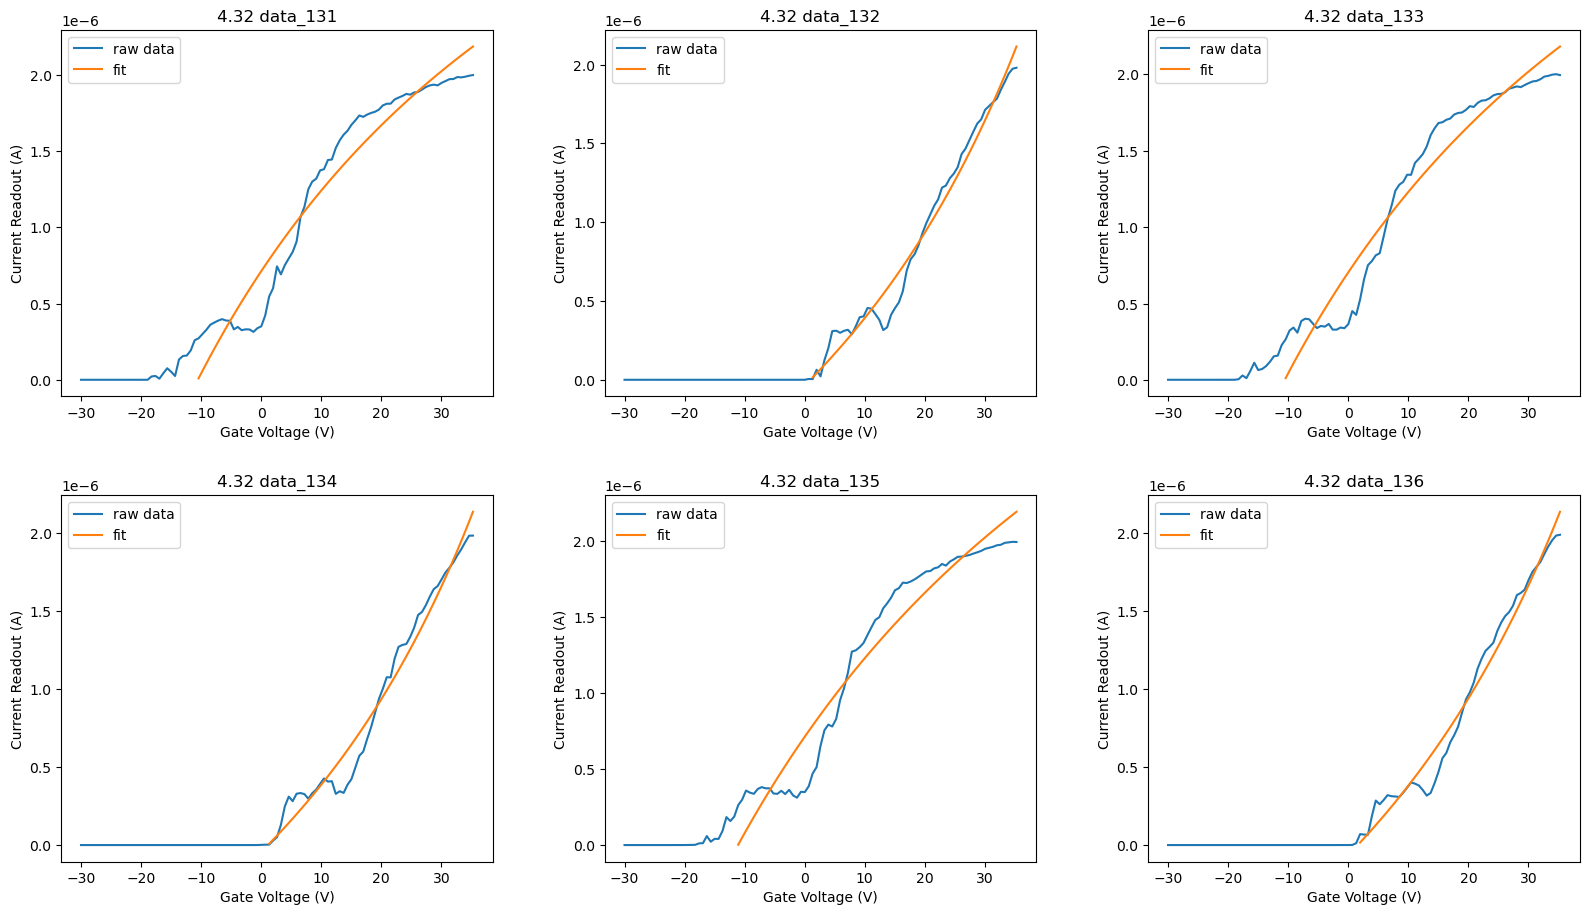

In [16]:
## CODE CHECKS OUT NOW IT WORKS ##
## NEXT STEP IS TO GET CONTACT SPACING ENTERED AS NANOMETERS and ELIMINATING CAPACITANCE. 

import array
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tabulate import tabulate

np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

# I think what's happening here is because its a function we're interpreting everything as
# literal in here but rather should be doing stuff as not literal - Very interesting.

## ALSO VBIAS AND L MUST BE PREDETERMINED BEFORE RUNNING ALL THIS SHIT HERE BRODY  ##
def read_file(filename):
    
    fit = []
    x = 0
    comp_flnm = '020124_M3635_60nm_2/' + filename + ".dat"
    
    with open(comp_flnm, 'r') as f:
        read_file = f.readlines()
    
    for line in read_file:
        
        if not (line.startswith('#') or line.startswith('\n')):
            
            fit.append([float(x) for x in line.split('\t')])
            
    fitnp = np.asarray(fit)
    
    n = len(fitnp)

    Vgate = fitnp[0:n,0] * 30e-3 
    Iout = fitnp[0:n,3] * 1e-6 
    
    return Vgate, Iout

# def yfit(x, vth, rc, u):
    
#     # Fit Function
#     I = (Vbias/rc) - Vbias*(L**2)/((L**2)*rc + (rc**2)*u*cap*(x-vth))
    
#     # Trimming
#     for i in range(n):
        
#         if x[i]<vth:
#             S[i] = 0     
#         else:
#             S[i] = 1
            
#     return I*S

def trunc(x, vth, rc, u):
    
    # Truncated array 
    trunc_vb = []
    trunc_curr = []

    # Fit Function
    I = (Vbias/rc) - Vbias*(L**2)/((L**2)*rc + (rc**2)*u*cap*(x-vth))
      
    # Trimming
    for i in range(n):
        
        if x[i]>=vth:
            
            trunc_vb.append(x[i])
            trunc_curr.append(I[i])
            
    return trunc_vb, trunc_curr

def shape_4_tabulate(Vth, r, mu, data_ids):

    Vth_avg = np.mean(Vth)
    Vth.append(Vth_avg)

    r_avg = np.mean(r)
    r.append(r_avg)

    mu_avg = np.mean(mu)
    mu.append(mu_avg)
    
    if len(data_ids) == 1: 
        Names = data_ids
    
    else: 
        Names = data_ids
        Names.append("Average")

    return Vth, r, mu, Names

data = {
    
    "4.32" : [["data_131", "data_132", "data_133", "data_134", "data_135", "data_136"],
            3e-5, 11.25e-18, 10e-3]
           #contact spacing - cm, capacitance - farads, Vbias - V) 

}

#You may have to do like plt.legend. You can do ax.legend()

for key in data:
    
    if len(data[key][0]) == 6:
        
        fig,axs = plt.subplots(nrows = 2, ncols = 3, figsize = (17,10)) #axs multiple axes # Figure Size
        fig.tight_layout(pad = 5.0)
        
    if len(data[key][0]) == 3:

        fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (17,10)) #axs multiple axes # Figure Size
        fig.tight_layout(pad = 5.0)
        
    if len(data[key][0]) == 1:
        
        fig,axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6)) #axs multiple axes # Figure Size
        fig.tight_layout(pad = 5.0)
        
    else:
        
        fig,axs = plt.subplots(nrows = 2, ncols = 3, figsize = (17,10)) #axs multiple axes # Figure Size
        fig.tight_layout(pad = 5.0)
    

    ## THIS CHECKS OUT -> Correct values are retreived 
    L = data[key][1]
    print("Contact Spacing: " + str(L) + " cm")
    cap = data[key][2]
    print("Capacitance: " + str(cap) + " F")
    Vbias = data[key][3]
    print("Bias Voltage: " + str(Vbias) + " V")
    print("\n")
    
    Vth = []
    r = []
    mu = []
    
    for i, data_file in enumerate(data[key][0]): # i helps enumerate and enumerate
        
        ## SOMEWHERE HER VBIAS AND L AND ALL THE OTHER STUFF WILL LIKELY AHVE TO GET INCLUDED
        
        Vg, I = read_file(data_file)
        
        n = len(Vg)
        S = np.empty(n)
         
        def yfit(x, vth, rc, u):
    
            # Fit Function
            I = (Vbias/rc) - Vbias*(L**2)/((L**2)*rc + (rc**2)*u*cap*(x-vth))

            # Trimming
            for i in range(n):

                if x[i]<vth:
                    S[i] = 0     
                else:
                    S[i] = 1

            return I*S
                
        # Extract parameter and StdDev
        popt,pcov = curve_fit(yfit, Vg, I)
        perr = np.sqrt(np.diag(pcov))
        
        ax = np.ravel(axs)[i] #flattens the 2x3 axes into a list of 6 objects and iterates thorugh it.
        ax.plot(Vg, I) # Axes objects have mehtods that do plotting for you. Ax 
                       # has almost same functions as plot

        # fit plot
        ax.plot(trunc(Vg,popt[0], popt[1], popt[2])[0],
                trunc(Vg,popt[0], popt[1], popt[2])[1])
        
        ax.set_xlabel("Gate Voltage (V)")
        ax.set_ylabel("Current Readout (A)")
        ax.set_title(key + " " + data_file)
        ax.legend(['raw data', "fit"])
        
        # Adds Values
        Vth.append(popt[0])
        r.append(popt[1])
        mu.append(popt[2])
        
    Vth, r, mu, Names = shape_4_tabulate(Vth, r, mu, data[key][0])

    head = [key, "µ [cm^2/(V*s)]", "Resistance [Ω]", "Threshold Voltage [V]"]
    
    print(tabulate(list(zip(Names, mu, r, Vth)), headers = head))
    print("\n")
    
    # content2 = tabulate(list(zip(Names, mu, r, Vth)), headers = head)
    # text_file=open("output.csv","w")
    # text_file.write(content2)
    # text_file.close()
    